In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mygrad.components as mc
import mygrad.functional as mf
from mygrad.losses import BinaryCrossEntropy, CategorialCorssEntropy
from mygrad.optimizers import SGD , RMSProp
from mygrad.preprocessors import MinMaxScaler, StandardScaler, IdentityScaler
from mygrad.trainers import BinaryClassificationTrainer, CategoricalClassificationTrainer, ProgressBar, EarlyStopping
from mygrad.dataloaders import NumpyRegressionDataloader, NumpyClassificationDataloader

/tmp/ipykernel_11757/309102904.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Rings 3 Regular

In [2]:
train_df = pd.read_csv("../mio1/classification/rings3-regular-training.csv")
test_df = pd.read_csv("../mio1/classification/rings3-regular-test.csv")

In [3]:
train_df["c"]

0       0
1       0
2       0
3       0
4       0
       ..
1495    2
1496    2
1497    2
1498    2
1499    2
Name: c, Length: 1500, dtype: int64

In [4]:
train_df.head()

,x,y,c
0,-93.563317,-76.345110,0
1,1.060114,-16.727040,0
2,24.396099,40.358822,0
3,-94.595137,-97.889250,0
4,-85.331382,-56.736933,0


Text(0.5, 1.0, 'Wizualizacja zbioru treningowego rings3-regular')

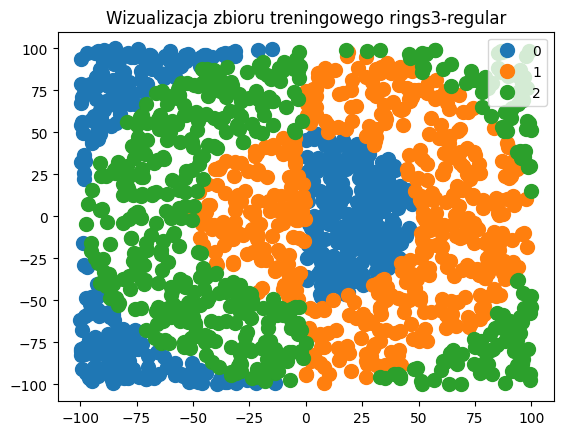

In [25]:
groups = train_df.groupby('c')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=10, label=name)

plt.legend(loc="upper right")
plt.title("Wizualizacja zbioru treningowego rings3-regular")

Text(0.5, 1.0, 'Wizualizacja zbioru treningowego rings3-regular po usunięciu środka')

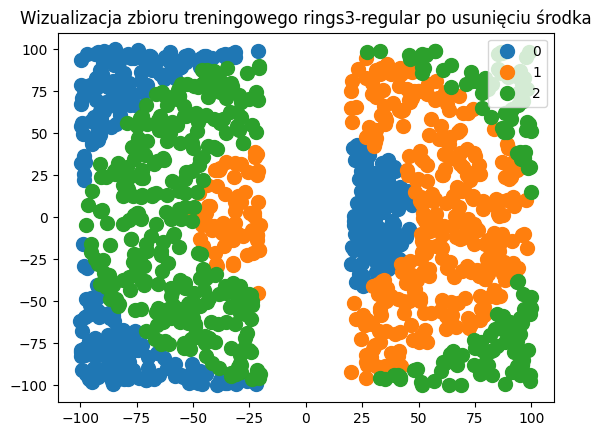

In [26]:
reduced_train_df= train_df[(train_df["x"] < -20) | (train_df["x"] > 20)]

groups = reduced_train_df.groupby('c')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=10, label=name)

plt.legend(loc="upper right")
plt.title("Wizualizacja zbioru treningowego rings3-regular po usunięciu środka")

In [48]:
X_train = reduced_train_df[["x", "y"]].values
y_train = reduced_train_df["c"].values

In [61]:
X_train = train_df[["x", "y"]].values
y_train = train_df["c"].values.reshape(-1, 1) * 1

In [62]:
np.unique(y_train)

array([0, 1, 2])

In [63]:
X_train.shape, y_train.shape

((1500, 2), (1500, 1))

In [64]:
input_normalizer = StandardScaler()

X_train_scaled = input_normalizer.fit_transform(X_train)

In [65]:
X_test = test_df[["x", "y"]].values
X_test_scaled = input_normalizer.transform(X_test)
y_test = test_df["c"].values.reshape(-1, 1) * 1

## Softmax

In [66]:
y_train_onehot = mf.onehot_encode(y_train, 3)
y_test_onehot = mf.onehot_encode(y_test, 3)

In [67]:
model = mc.Sequential(
    mc.Linear(2, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 10, init="he"),
    mc.ReLU(),
    mc.Linear(10, 3, init="xavier"),
    mc.Softmax(),
)
optimizer = RMSProp(model.parameters(), learning_rate=0.001)
loss = CategorialCorssEntropy()

train_dataloader = NumpyClassificationDataloader(X_train_scaled, y_train_onehot, batch_size=20, shuffle=True, is_one_hot=True)
validation_dataloader = NumpyClassificationDataloader(X_test_scaled, y_test_onehot, batch_size=100, is_one_hot=True)
trainer = CategoricalClassificationTrainer(model, optimizer, loss, train_dataloader, validation_dataloader, plugins=[
    ProgressBar(),
    EarlyStopping(patience=100, metric="fscore", mode="max")
])
train_outputs = trainer.train(5000)

Training epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Early stopping at epoch 414


Text(0, 0.5, 'Cross entropy')

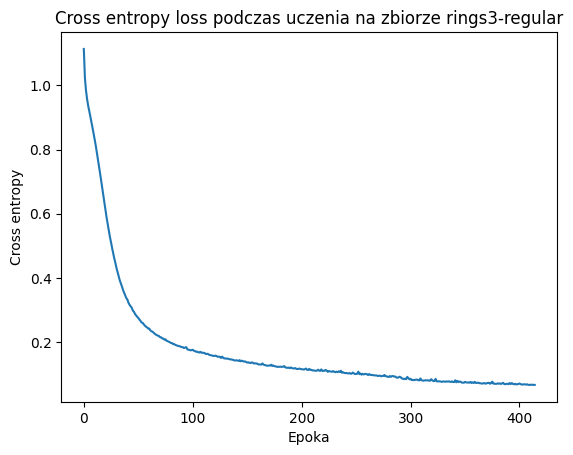

In [68]:
plt.plot(train_outputs["loss"])
plt.title("Cross entropy loss podczas uczenia na zbiorze rings3-regular")
plt.xlabel("Epoka")
plt.ylabel("Cross entropy")

Text(0, 0.5, 'F1 Score')

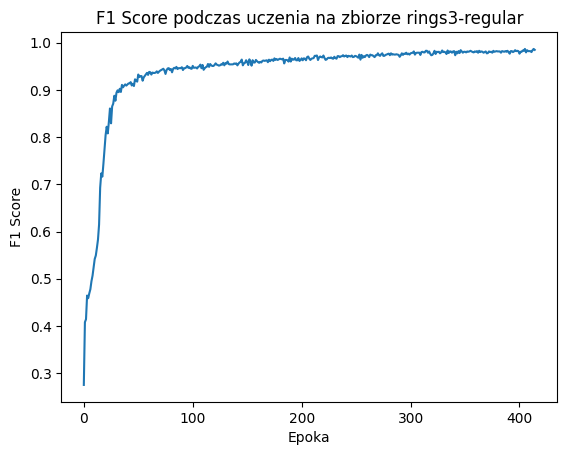

In [69]:
plt.plot(train_outputs["fscore"])
plt.title("F1 Score podczas uczenia na zbiorze rings3-regular")
plt.xlabel("Epoka")
plt.ylabel("F1 Score")

In [70]:
y_pred_scaled = model.forward(X_test_scaled)
y_pred = np.argmax(y_pred_scaled, axis=1)

print(f"F-score: {mf.fscore(y_pred, y_test, 3)}")


F-score: 0.9594376129992379


Text(0.5, 1.0, 'Wizualizacja zbioru testowego rings3-regular')

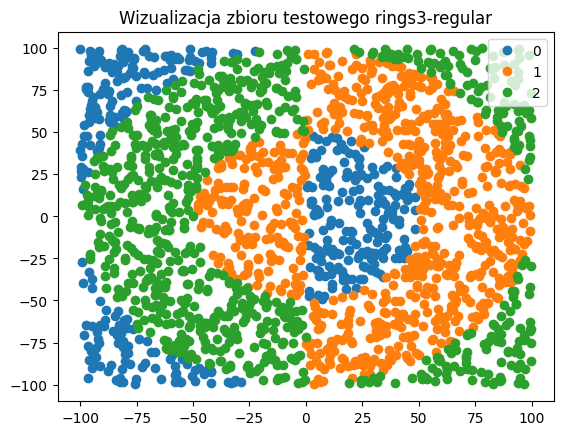

In [71]:
groups = test_df.groupby('c')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=6, label=name)

plt.legend(loc="upper right")
plt.title("Wizualizacja zbioru testowego rings3-regular")

Text(0.5, 1.0, 'Wizualizacja predykcji na zbiorze rings3-regular')

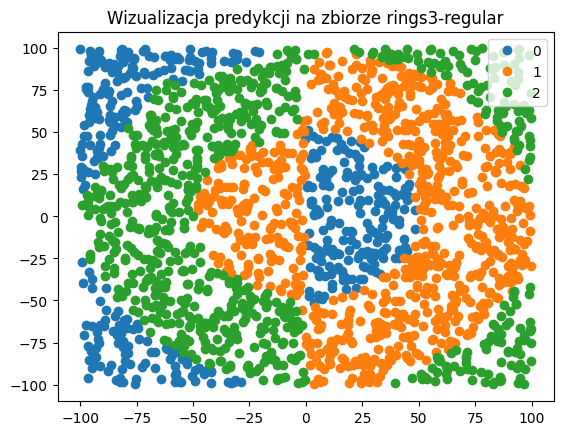

In [72]:
pred_df = pd.DataFrame(X_test, columns=["x", "y"])
pred_df["c"] = y_pred

groups = pred_df.groupby('c')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=6, label=name)

plt.legend(loc="upper right")
plt.title("Wizualizacja predykcji na zbiorze rings3-regular")


Text(0.5, 1.0, 'Wizualizacja poprawności predykcji \nna zbiorze testowym rings3-regular')

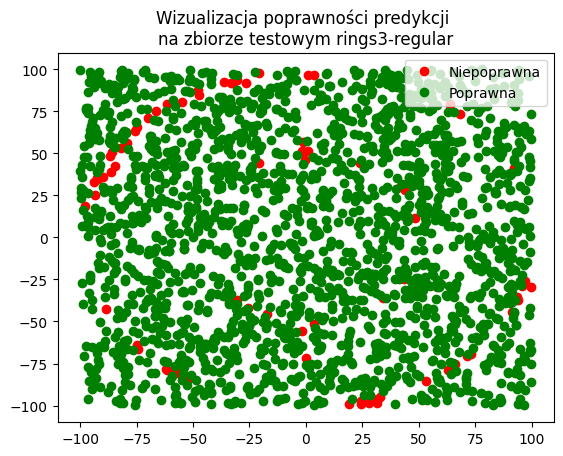

In [73]:
compare_df = pd.DataFrame(X_test, columns=["x", "y"])
compare_df["c"] = y_pred == y_test.flatten()

groups = compare_df.groupby('c')
for name, group in groups:
    if name:
        plt.plot(group.x, group.y, marker='o', linestyle='', markersize=6, color="green", label="Poprawna")
    else:
        plt.plot(group.x, group.y, marker='o', linestyle='', markersize=6, color="red", label="Niepoprawna")


plt.legend(loc="upper right")
plt.title("Wizualizacja poprawności predykcji \nna zbiorze testowym rings3-regular")